<a href="https://colab.research.google.com/github/ygeszvain/projects/blob/master/Prices_Analysis(electronic_products).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install rfpimp
! pip install eli5

  Stored in directory: /root/.cache/pip/wheels/c7/35/67/4065afd69df4c0be693ecdec8a9c1433a23f80ee60395272ba
Successfully built rfpimp
     |████████████████████████████████| 102kB 4.7MB/s 


In [2]:
!pip install kaggle

In [11]:
!mkdir .kaggle

mkdir: cannot create directory ‘.kaggle’: File exists


In [0]:
import json
token = {"username":"ygeszvain","key":"dd372cdf797a4dd2ce42075be6ec8b83"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [14]:
!kaggle config set -n path -v/content

- path is now set to: /content


In [15]:
!kaggle datasets download -d datafiniti/electronic-products-prices

 55% 5.00M/9.17M [00:00<00:00, 20.7MB/s]
100% 9.17M/9.17M [00:00<00:00, 30.6MB/s]


In [16]:
!unzip datasets/datafiniti/electronic-products-prices/electronic-products-prices.zip

Archive:  datasets/datafiniti/electronic-products-prices/electronic-products-prices.zip
  inflating: DatafinitiElectronicsProductsPricingData.csv  


In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import numpy as np  # arrays and math functions
# visualisations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib

%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.preprocessing import LabelEncoder
from scipy.stats import uniform  # for training-and-test split

# import packages for analysis and modeling
import pandas as pd  # data frame operations
import numpy as np  # arrays and math functions
from scipy.stats import uniform  # for training-and-test split
import statsmodels.api as sm  # statistical models (including regression)
import statsmodels.formula.api as smf  # R-like model specification
import matplotlib.pyplot as plt  # 2D plotting
import seaborn as sns  # PROVIDES TRELLIS AND SMALL MULTIPLE PLOTTING
#from pyvttbl import DataFrame # Anova
from scipy import stats
from statsmodels.formula.api import ols
import scipy.stats as stats
from sklearn import linear_model
from shapely.geometry import Point, Polygon
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

sns.set_style("whitegrid")
sns.set(rc = {'figure.figsize':(15, 10)})
matplotlib.rcParams['figure.figsize'] = (15, 10)

In [18]:
df = pd.read_csv('DatafinitiElectronicsProductsPricingData.csv')
df.head()

,id,prices.amountMax,prices.amountMin,prices.availability,prices.condition,prices.currency,prices.dateSeen,prices.isSale,prices.merchant,prices.shipping,prices.sourceURLs,asins,brand,categories,dateAdded,dateUpdated,ean,imageURLs,keys,manufacturer,manufacturerNumber,name,primaryCategories,sourceURLs,upc,weight,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30
0,AVphzgbJLJeJML43fA0o,104.99,104.99,Yes,New,USD,"2017-03-30T06:00:00Z,2017-03-10T22:00:00Z,2017...",False,Bestbuy.com,NaN,http://www.bestbuy.com/site/sanus-tv-wall-moun...,B00C78VIUE,Sanus,"Audio & Video Accessories,TV Mounts,TV Accesso...",2015-04-13T12:00:51Z,2018-05-12T18:59:48Z,NaN,https://images-na.ssl-images-amazon.com/images...,sanusvlf410b110inchsuperslimfullmotionmountfor...,NaN,VLF410B1,Sanus VLF410B1 10-Inch Super Slim Full-Motion ...,Electronics,https://www.amazon.com/Sanus-VLF410B1-10-Inch-...,7.93796E+11,32.8 pounds,NaN,NaN,NaN,NaN,NaN
1,AVpgMuGwLJeJML43KY_c,69.00,64.99,In Stock,New,USD,2017-12-14T06:00:00Z,True,Walmart.com,Expedited,https://www.walmart.com/ip/BOYTONE-BT210FB-BLA...,"B018K251JE,B00VILQKQ8",Boytone,"Stereos,Portable Bluetooth Speakers,TV, Video ...",2015-05-18T14:14:56Z,2018-06-13T19:39:02Z,NaN,https://images-na.ssl-images-amazon.com/images...,boytone2500w21chhometheatersystemblackdiamond/...,Boytone,BT-210F,Boytone - 2500W 2.1-Ch. Home Theater System - ...,Electronics,http://reviews.bestbuy.com/3545/4784804/review...,6.42015E+11,14 pounds,NaN,NaN,NaN,NaN,NaN
2,AVpgMuGwLJeJML43KY_c,69.00,69.00,In Stock,New,USD,2017-09-08T05:00:00Z,False,Walmart.com,Expedited,https://www.walmart.com/ip/Boytone-BT-210F-Blu...,"B018K251JE,B00VILQKQ8",Boytone,"Stereos,Portable Bluetooth Speakers,TV, Video ...",2015-05-18T14:14:56Z,2018-06-13T19:39:02Z,NaN,https://images-na.ssl-images-amazon.com/images...,boytone2500w21chhometheatersystemblackdiamond/...,Boytone,BT-210F,Boytone - 2500W 2.1-Ch. Home Theater System - ...,Electronics,http://reviews.bestbuy.com/3545/4784804/review...,6.42015E+11,14 pounds,NaN,NaN,NaN,NaN,NaN
3,AVpgMuGwLJeJML43KY_c,69.99,69.99,Yes,New,USD,2017-10-10T05:00:00Z,False,Bestbuy.com,NaN,https://www.bestbuy.com/site/boytone-2500w-2-1...,"B018K251JE,B00VILQKQ8",Boytone,"Stereos,Portable Bluetooth Speakers,TV, Video ...",2015-05-18T14:14:56Z,2018-06-13T19:39:02Z,NaN,https://images-na.ssl-images-amazon.com/images...,boytone2500w21chhometheatersystemblackdiamond/...,Boytone,BT-210F,Boytone - 2500W 2.1-Ch. Home Theater System - ...,Electronics,http://reviews.bestbuy.com/3545/4784804/review...,6.42015E+11,14 pounds,NaN,NaN,NaN,NaN,NaN
4,AVpgMuGwLJeJML43KY_c,66.99,66.99,Yes,New,USD,2017-08-28T07:00:00Z,False,Bestbuy.com,NaN,https://www.bestbuy.com/site/boytone-2500w-2-1...,"B018K251JE,B00VILQKQ8",Boytone,"Stereos,Portable Bluetooth Speakers,TV, Video ...",2015-05-18T14:14:56Z,2018-06-13T19:39:02Z,NaN,https://images-na.ssl-images-amazon.com/images...,boytone2500w21chhometheatersystemblackdiamond/...,Boytone,BT-210F,Boytone - 2500W 2.1-Ch. Home Theater System - ...,Electronics,http://reviews.bestbuy.com/3545/4784804/review...,6.42015E+11,14 pounds,NaN,NaN,NaN,NaN,NaN


In [0]:
data = df.copy()

In [20]:
data = data[['id','prices.amountMax','prices.amountMin','prices.availability','prices.condition','brand','categories','name','manufacturer','weight']]
data['prices_avg'] = (data['prices.amountMax']+data['prices.amountMin'])/2
data.describe()

,prices.amountMax,prices.amountMin,prices_avg
count,14592.000000,14592.000000,14592.000000
mean,509.578897,487.323215,498.451056
std,1008.512738,967.083200,984.733806
min,1.000000,1.000000,1.000000
25%,79.990000,79.950000,79.990000
50%,195.000000,188.035000,189.990000
75%,499.990000,499.000000,499.955000
max,26871.000000,26871.000000,26871.000000


In [0]:
data = data.rename(index=str, columns={"prices.amountMax": "amountMax", "prices.amountMin": "amountMin", "prices.availability": "availability", "prices.condition": "condition"})

In [0]:
# udfs ----

# function for creating a feature importance dataframe
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title):
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue') \
       .set_title(title, fontsize = 20)

In [0]:
data = data.rename(index=str, columns={"prices_avg": "target"})

In [24]:
data.columns

Index(['id', 'amountMax', 'amountMin', 'availability', 'condition', 'brand',
       'categories', 'name', 'manufacturer', 'weight', 'target'],
      dtype='object')

In [25]:
data.dtypes

id               object
amountMax       float64
amountMin       float64
availability     object
condition        object
brand            object
categories       object
name             object
manufacturer     object
weight           object
target          float64
dtype: object

In [26]:
data.availability.unique()

array(['Yes', 'In Stock', 'TRUE', 'undefined', 'yes', 'Out Of Stock',
       'Special Order', 'No', 'More on the Way', 'sold', 'FALSE',
       'Retired', '32 available', '7 available', nan, 'Limited Stock',
       'Discontinued', 'More Coming Soon'], dtype=object)

In [0]:
data.availability = data.availability.replace('FALSE', 'No')
data.availability = data.availability.replace('no', 'No')
data.availability = data.availability.replace('TRUE', 'Yes')
data.availability = data.availability.replace('yes', 'Yes')
data.availability = data.availability.replace('32 available', 'Yes')
data.availability = data.availability.replace('7 available', 'Yes')
data.availability = data.availability.replace('sold', 'Out Of Stock')
data.availability = data.availability.replace('Retired', 'Discontinued')
data.availability = data.availability.replace('More on the Way', 'More Coming Soon')
data.availability = data.availability.replace('undefined', np.nan)

In [28]:
data.condition.unique()

array(['New', 'new', 'Seller refurbished', 'Used', 'pre-owned',
       'Refurbished', 'Manufacturer refurbished',
       'New other (see details)', 'refurbished',
       'New Kicker BT2 41IK5BT2V2 Wireless Bluetooth USB Audio System Black + Remote, Power Supply (volts, ampere): 24, 2.9, Square Reflex Subwoofer (in., mm): 6 x 6", Stereo Amp Power with DSP (watts): 50, App for customizing - KickStart, Remote Control Included, Height x Width x Depth (in, mm): 8.87" x 19" x 9.14", Frequency Response (Hz): 24-20k, +-3dB, Woofer (in., cm): 5", 1 Year Manufacturer Warranty, Item Weight: 13.85 lbs., USB Port, Compatible with: Bluetooth-enabled devices, Aux-in, Speaker Design: 2-Way Full-Range, Bluetooth wireless streaming, Condition: Brand New!, Tweeter (in., cm): 3/4"',
       '5/16" Ring Terminal, 3 ft. 8 GA Black Ground Cable, 6 ft. Split Loom Tubing, Depth: 6.5" (165mm) (top) 11.2" (285mm) (bottom), Item Weight: 18.5 lbs., Frequency Response 25Hz - 500Hz, Line Output, Max Power: 1100 Watt 

In [0]:
data.condition = data.condition.replace('new', 'New')
data.condition = data.condition.replace('Seller refurbished', 'Refurbished')
data.condition = data.condition.replace('Manufacturer refurbished', 'Refurbished')
data.condition = data.condition.replace('new', 'New')
data.condition = data.condition.replace('New Kicker BT2 41IK5BT2V2 Wireless Bluetooth USB Audio System Black + Remote, Power Supply (volts, ampere): 24, 2.9, Square Reflex Subwoofer (in., mm): 6 x 6", Stereo Amp Power with DSP (watts): 50, App for customizing - KickStart, Remote Control Included, Height x Width x Depth (in, mm): 8.87" x 19" x 9.14", Frequency Response (Hz): 24-20k, +-3dB, Woofer (in., cm): 5", 1 Year Manufacturer Warranty, Item Weight: 13.85 lbs., USB Port, Compatible with: Bluetooth-enabled devices, Aux-in, Speaker Design: 2-Way Full-Range, Bluetooth wireless streaming, Condition: Brand New!, Tweeter (in., cm): 3/4"', 'New')
data.condition = data.condition.replace('New other (see details)', 'New')
data.condition = data.condition.replace('5/16" Ring Terminal, 3 ft. 8 GA Black Ground Cable, 6 ft. Split Loom Tubing, Depth: 6.5" (165mm) (top) 11.2" (285mm) (bottom), Item Weight: 18.5 lbs., Frequency Response 25Hz - 500Hz, Line Output, Max Power: 1100 Watt x 1 Channel @ 2 Ohm, 30 ft. Speaker Wire, Boss Illuminated Logo, Height: 12.8" (325mm), (3) Rubber Grommets, Item Weight: 2 lbs., Size 10", 20 ft. 8 GA Red Power Cable, Ported enclosure for greater output and deeper bass, 2 Ohm Stable, Class A/B, Voice Coil Size 2", Black rubber surround, Nominal Impedance 4 ohm, Rugged fiberboard construction with thick carpet covering, Warranty: 1 Year Manufacturer Warranty, MOSFET Power, Weight: 6 lbs, Width: 17.7" (450mm), Condition: Brand New!, Low Pass Crossover, List item, RMS Power: 250 Watt x 1 Channel @ 4 Ohm, Remote Bass Control Included!, 1/4" Ring Terminal, 16 ft. 18 GA Blue Turn-On Wire, Peak Power: 500 Watts, Competition High Quality Fuse Holder, Condition: BRAND NEW!, Product Condition: Brand New, RMS Power: 175 Watts, Aluminum woofer cone, THD: 0.01%, 1 Year Manufacturer Warranty, Dimensions: 10-7/16" (W) x 2-1/4" (H) x 9-1/8" (L), #10 Ring Terminal, 20 ft. High Performance Black RCA, SPL (db @ 1w/1m) 88dB, New Dual SBX101 10" 500 Watts Car Audio Subwoofer Sub + Ported Sub Enclosure, (20) 4" Wire Ties', 'New')
data.condition = data.condition.replace('Brand New', 'New')
data.condition = data.condition.replace('Top-mount Depth: 3-1/8", 2) New Kicker 41KSC6934 6x9" 3-Way 300 Watt Car Audio Coaxial Speakers KSC693, Item Weight: 8 lbs., 3/4" silk dome tweeter, 4 ohms impedance, Tweeter Magnet: Neodymium, Tweeter Protrusion: 3/16, Rubber surround, Peak: 300 watts, Mounting Hole Diameter: 5-11/16x8-7/16", 1 Year Manufacturer Warranty, RMS: 150 watts, Bottom Mount Depth: 3-5/8", Grilles: Yes, Frequency Response: 30-21,000 Hz, Sensitivity: 92dB, Polypropylene midwoofer, Condition: Brand New!', 'New')
data.condition = data.condition.replace('Product warranty: 1-year warranty, Top-mount Depth: 3-1/8", Item Weight: 8 lbs., 3/4" silk dome tweeter, 4 ohms impedance, Tweeter Magnet: Neodymium, Tweeter Protrusion: 3/16, Rubber surround, Peak: 300 watts, Mounting Hole Diameter: 5-11/16x8-7/16", RMS: 150 watts, Bottom Mount Depth: 3-5/8", Grilles: Yes, Kicker 41KSC6934 6x9" 3-Way 300 Watt Car Audio Coaxial Speakers KSC693, Frequency Response: 30-21,000 Hz, Quantity: 4 speakers, Sensitivity: 92dB, Polypropylene midwoofer, Condition: Brand New!', 'New')
data.condition = data.condition.replace('pre-owned', 'Used')
data.condition = data.condition.replace('refurbished', 'Refurbished')
data.condition = data.condition.replace('Magnet - Neodymium, SearsCondition - Refurbished, Refresh Rate - 4Hz - 100kHz, Headphone Type - Over the Head, Driver Unit - 70mm, Power Handling (Watts) - 2000mW, Plug Type - 3.5mm, Audio Accessories - Headphones, Headphone Uses - Audiophile; iPod, Color - Black; Black, Impedance - 70 ohm, Cable Length - 6 - 6.99 Feet; 9 - 9.99 Feet, Sensitivity - 102dB, Headphone Styles - Over-ear', 'Refurbished')
data.condition = data.condition.replace('iPod Skip/2 Speed Search Function, Surround: Cloth, Random/Repeat Play, Loudness, Impedance 4 ohms, Front AUX & USB Interface with slide protection cover, iPod/iPhone Direct Connection with Optional cable*1, FM Stereo/Mono Selector, Bass Boost, Frequency Response: 35 Hz - 20k Hz, Variable Color Illumination, General Features, Item Weight: 2 lbs., CD-R/CD-RW Compatible, 13 Digit 1.5Line LCD Display, Sirius XM (SXV100/200/300) Ready, RBDS with Radio Text, USB Features, Sensitivity: 92 dB / W / m, Built-in LPF/HPF, Equalizer (13Band), CD Text Ready, Subwoofer Level Adjustable, Dimmer Control Function (Manual/Set by timer), Magnet: Ferrite, Weight of Magnet (Woofer): 0.2lbs, Rotary Encoder and Direct Key (TEL) for easy operation, Android Rapid Charge, MP3, WMA, AAC, WAV, FLAC Decoder with ID-3 Tag Display, Drive Change (For Android or Card Reader), Diaphragm: PP Cone, RMS Power: 30W, Digital Clock (12H), MP3, WMA, AAC Decoder with ID-3 Tag Display, 1 Year VMInnovations Warranty, AME (Automatic Memory Entry), 0-bit Mute, Condition: Brand New!, Wireless Music Browsing, Basket Steel: Black, Dual Phone Connection, Drive EQ, Part Number: DPX502BT, Up/Down Seek Tuning, Backup Memory for Tuner Preset, Folder Name Manual Search Function without Stopping Audio-play, Mounting Depth: 1-11/16inch, Stage EQ, Condition: New, Multi language(English, Spanish), FM/AM 24 Station Presets (18FM, 6AM), Kenwood sound reconstruction, restores musical to compressed music, Cutout Diameter: 4-7/8inch, System Q, Woofer: 6-1/2inch PP Cone, Android Music Playback, CD Features, MP3/WMA/AAC/WAV/FLAC Files Playback with ID-3 Tag Display, MAX Power: 300W, Audio Features, Maximum Output Power : 50W x 4 (MOSFET Power IC), 3 Preout (2.5V), Tuner Features, Pandora / iHeart Radio App Ready (iPhone App)', 'New')
data.condition = data.condition.replace('Pioneer 10" TS-SW2502 Pre-Load Shallow Subwoofer Enclosure, Frequency Response: 93dB, Oversized Cone Structure, Compact-Space Saving Design, Cone Material: MICA injection-molded resin, Part Number: TS-SWX2502 (TSSWX2502), Impedance: Single 4 Ohm, Enclosure Dimensions: 18-5/8" x 13 7/8" x 6", RMS Power: 300 Watts, Max Power: 1200 Watts, 1 Year Warranty, Condition: Brand New!', 'New')
data.condition = data.condition.replace('For parts or not working', np.nan)

In [30]:
data.categories.unique()

array(['Audio & Video Accessories,TV Mounts,TV Accessories & Parts,Electronics,A/V Presentation,Accessories & Supplies,TV Ceiling & Wall Mounts',
       'Stereos,Portable Bluetooth Speakers,TV, Video & Home Audio,Speaker Systems,Portable Audio & Video,Electronics,See more Black BOYTONE Bt-210f 30 Watt FM Radio Bluetoo...,Speakers,Home Audio & Theater,All Home Speakers,Consumer Electronics,See more BOYTONE Bt-210f Bluetooth Wireless Speaker Mp3...,Home Theater Systems,MP3 Player Accessories,Home Audio,Audio,Cell,Stereo Shelf Systems',
       'Computers,Office,Computer Accessories,Computer Accessories & Peripherals,Laptop Accessories,Laptop Chargers & Adapters,Computers & Tablets,Electronics,Battery Chargers,Batteries,Office Technology',
       ...,
       'Electronics,GPS & Navigation,Vehicle GPS,Auto GPS Units,Consumer Electronics,Vehicle Electronics & GPS,GPS Units,Car Electronics & GPS,GPS Navigation & Accessories,Portable GPS,Handheld GPS Units',
       'Pro Audio,Sound Reinforcemen

In [31]:
data.manufacturer.unique()

array([nan, 'Boytone', 'Dantona', 'YAMAHA', 'Bose', 'Motorola',
       'TRANSCEND Storage', 'SAMSUNG', 'Peerless', 'Kenwood', 'Microsoft',
       'Denaq', 'Peak Design', 'Lowepro', 'iHome', 'Polk Audio', 'BOSE',
       'Lenovo Idea', 'ELITE SCREENS DIRECTSHIP', 'Russound',
       'Western Digital', 'House Of Marley', 'Midland', 'Marantz',
       'ISIMPLE', 'Chief Manufacturing', 'Peerless Industries',
       'Siriusxm', 'Slingbox', 'Sony', 'Power Acoustik', 'Elitescreens',
       'Novatel', 'Pelican', 'Audioquest', 'Lenovo', 'Razer', 'Samsung',
       'Canon', 'Logitech', 'TP-Link', 'Elite Screens', 'JBL', '5 Years',
       'Yamaha', 'Corsair', 'Allround Software', 'House of Marley',
       'Belkin', 'Grace Digital', 'Alpine', 'Parts', 'StarTech', 'Acer',
       'Samsung IT', 'RAZER', 'Planet Audio', 'Cybertronpc',
       'Samsung Electronics', 'Sennheiser', 'Grace Digital Audio',
       'KENWOOD', 'Actiontec', 'SiriusXM', 'Razer USA',
       'Jvc Real Sound System Z Series Ha-Sz2000 S

In [32]:
data.weight.unique()

array(['32.8 pounds', '14 pounds', '1.2 pounds', '13.2 pounds',
       '1.6 lb 2.6 lb 1.6 lb 18.7 lb', '1.1 pounds', '1.18 lb',
       '0.14 ounces', '3.2 ounces', '6.7 ounces', '13.6 ounces',
       '0.017 pounds', '1.32 lb', '6.5 pounds', '5.2 pounds', '3 ounces',
       '5.6 ounces', '3.88 oz', '5 pounds', '150 pounds', '2.2 pounds',
       '11.79 pounds', '3.8 pounds', '3.0 lbs', '4 pounds', '4 ounces',
       '1.5 pounds', '5.0 oz', '2.9 lb', '27.8 pounds', '12.5 ounces',
       '26 pounds', '16.48 ounces', '0.8 ounces', '8 pounds', '5.2 lb',
       '18.7 lb', '32 pounds', '7.2 pounds', '34.8 lb', '4.2 pounds',
       '43.2 pounds', '1.52 lb', '0.6 ounces', '1.4 pounds',
       '22.1 pounds', '1.8 pounds', '2.4 ounces', '78.1 pounds',
       '50 pounds', '1.41 pounds', '7.2 ounces', '2 pounds', '2 ounces',
       '1.96 pounds', '3 pounds', '1.25 pounds', '9.3 pounds', '0.63 oz',
       '6.3 pounds', '3.1 lb', '3.3 lb', '8 lb', '8.05 pounds',
       '1.8 lbs                        

In [33]:
# Label encoding

lb_make = LabelEncoder()
data["availability_code"] = lb_make.fit_transform(data["availability"].astype(str))
data[["availability", "availability_code"]].head(11)

,availability,availability_code
0,Yes,7
1,In Stock,1
2,In Stock,1
3,Yes,7
4,Yes,7
5,In Stock,1
6,In Stock,1
7,Yes,7
8,In Stock,1
9,In Stock,1


In [34]:
# Label encoding

lb_make = LabelEncoder()
data["categories_code"] = lb_make.fit_transform(data["categories"].astype(str))
data[["categories", "categories_code"]].head(11)

,categories,categories_code
0,"Audio & Video Accessories,TV Mounts,TV Accesso...",72
1,"Stereos,Portable Bluetooth Speakers,TV, Video ...",1049
2,"Stereos,Portable Bluetooth Speakers,TV, Video ...",1049
3,"Stereos,Portable Bluetooth Speakers,TV, Video ...",1049
4,"Stereos,Portable Bluetooth Speakers,TV, Video ...",1049
5,"Stereos,Portable Bluetooth Speakers,TV, Video ...",1049
6,"Stereos,Portable Bluetooth Speakers,TV, Video ...",1049
7,"Stereos,Portable Bluetooth Speakers,TV, Video ...",1049
8,"Stereos,Portable Bluetooth Speakers,TV, Video ...",1049
9,"Stereos,Portable Bluetooth Speakers,TV, Video ...",1049


In [35]:
# Label encoding

lb_make = LabelEncoder()
data["condition_code"] = lb_make.fit_transform(data["condition"].astype(str))
data[["condition", "condition_code"]].head(11)

,condition,condition_code
0,New,0
1,New,0
2,New,0
3,New,0
4,New,0
5,New,0
6,New,0
7,New,0
8,New,0
9,New,0


In [36]:
# Label encoding

lb_make = LabelEncoder()
data["brand_code"] = lb_make.fit_transform(data["brand"].astype(str))
data[["brand", "brand_code"]].head(11)

,brand,brand_code
0,Sanus,217
1,Boytone,36
2,Boytone,36
3,Boytone,36
4,Boytone,36
5,Boytone,36
6,Boytone,36
7,Boytone,36
8,Boytone,36
9,Boytone,36


In [37]:
# Label encoding

lb_make = LabelEncoder()
data["name_code"] = lb_make.fit_transform(data["name"].astype(str))
data[["name", "name_code"]].head(11)

,name,name_code
0,Sanus VLF410B1 10-Inch Super Slim Full-Motion ...,931
1,Boytone - 2500W 2.1-Ch. Home Theater System - ...,191
2,Boytone - 2500W 2.1-Ch. Home Theater System - ...,191
3,Boytone - 2500W 2.1-Ch. Home Theater System - ...,191
4,Boytone - 2500W 2.1-Ch. Home Theater System - ...,191
5,Boytone - 2500W 2.1-Ch. Home Theater System - ...,191
6,Boytone - 2500W 2.1-Ch. Home Theater System - ...,191
7,Boytone - 2500W 2.1-Ch. Home Theater System - ...,191
8,Boytone - 2500W 2.1-Ch. Home Theater System - ...,191
9,Boytone - 2500W 2.1-Ch. Home Theater System - ...,191


In [38]:
# Label encoding

lb_make = LabelEncoder()
data["manufacturer_code"] = lb_make.fit_transform(data["manufacturer"].astype(str))
data[["manufacturer", "manufacturer_code"]].head(11)

,manufacturer,manufacturer_code
0,NaN,265
1,Boytone,35
2,Boytone,35
3,Boytone,35
4,Boytone,35
5,Boytone,35
6,Boytone,35
7,Boytone,35
8,Boytone,35
9,Boytone,35


In [39]:
# Label encoding

lb_make = LabelEncoder()
data["weight_code"] = lb_make.fit_transform(data["weight"].astype(str))
data[["weight", "weight_code"]].head(11)

,weight,weight_code
0,32.8 pounds,537
1,14 pounds,274
2,14 pounds,274
3,14 pounds,274
4,14 pounds,274
5,14 pounds,274
6,14 pounds,274
7,14 pounds,274
8,14 pounds,274
9,14 pounds,274


In [40]:
d = {
    'feature_names':['availability_code','condition_code', 'brand_code', 'categories_code','name_code','manufacturer_code','weight_code']}
 
feature_names = pd.DataFrame(d,columns=['feature_names'])
feature_names

,feature_names
0,availability_code
1,condition_code
2,brand_code
3,categories_code
4,name_code
5,manufacturer_code
6,weight_code


In [0]:
y = data[["target"]]
X = pd.DataFrame(data, columns = feature_names.feature_names)
np.random.seed(seed = 42)
X['random'] = np.random.random(size = len(X))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.8, random_state = 42)

Text(0.5, 1.0, 'Random feature vs. target variable')

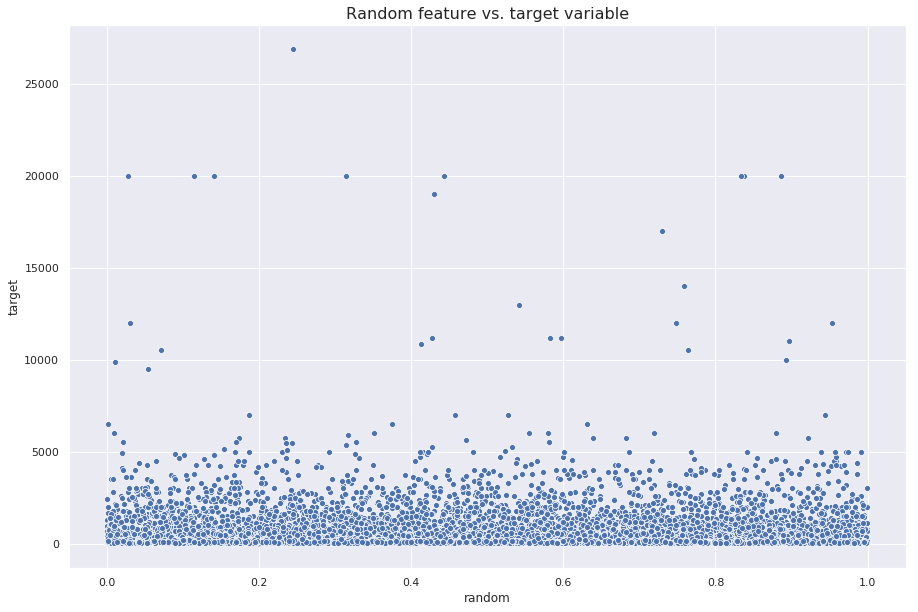

In [42]:
sns.scatterplot(x = 'random', y = 'target', data = X.assign(target = y)).set_title('Random feature vs. target variable', fontsize = 16)

Text(0.5, 1.0, 'Correlation matrix')

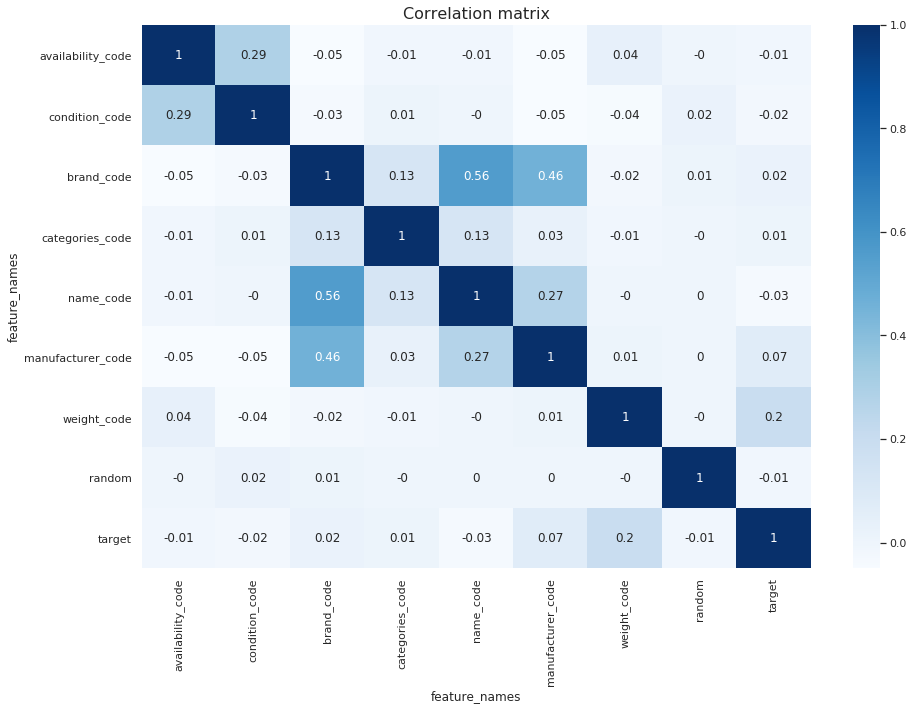

In [43]:
sns.heatmap(X.assign(target = y).corr().round(2), cmap = 'Blues', annot = True).set_title('Correlation matrix', fontsize = 16)

In [44]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)
rf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=True, random_state=42, verbose=0,
                      warm_start=False)

In [45]:
print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(X_train, y_train), 
                                                                                    rf.oob_score_,
                                                                                    rf.score(X_test, y_test)))

R^2 Training Score: 0.94 
OOB Score: 0.63 
R^2 Validation Score: 0.63


In [46]:
base_imp = imp_df(X_train.columns, rf.feature_importances_)
base_imp

,feature,feature_importance
0,categories_code,0.297492
1,weight_code,0.280602
2,name_code,0.149997
3,random,0.141131
4,brand_code,0.046970
5,availability_code,0.043381
6,manufacturer_code,0.029537
7,condition_code,0.010891


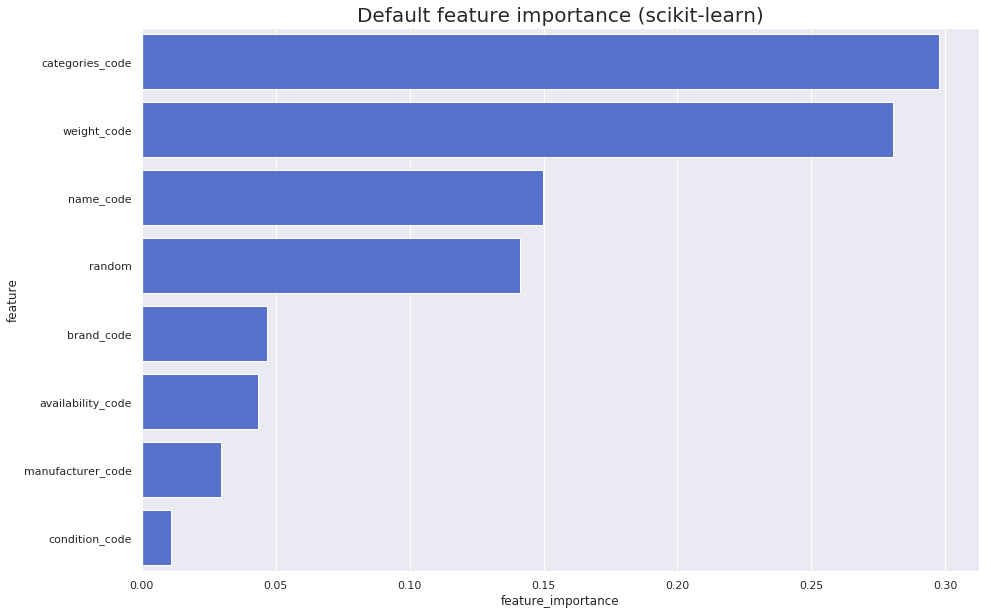

In [47]:
var_imp_plot(base_imp, 'Default feature importance (scikit-learn)')

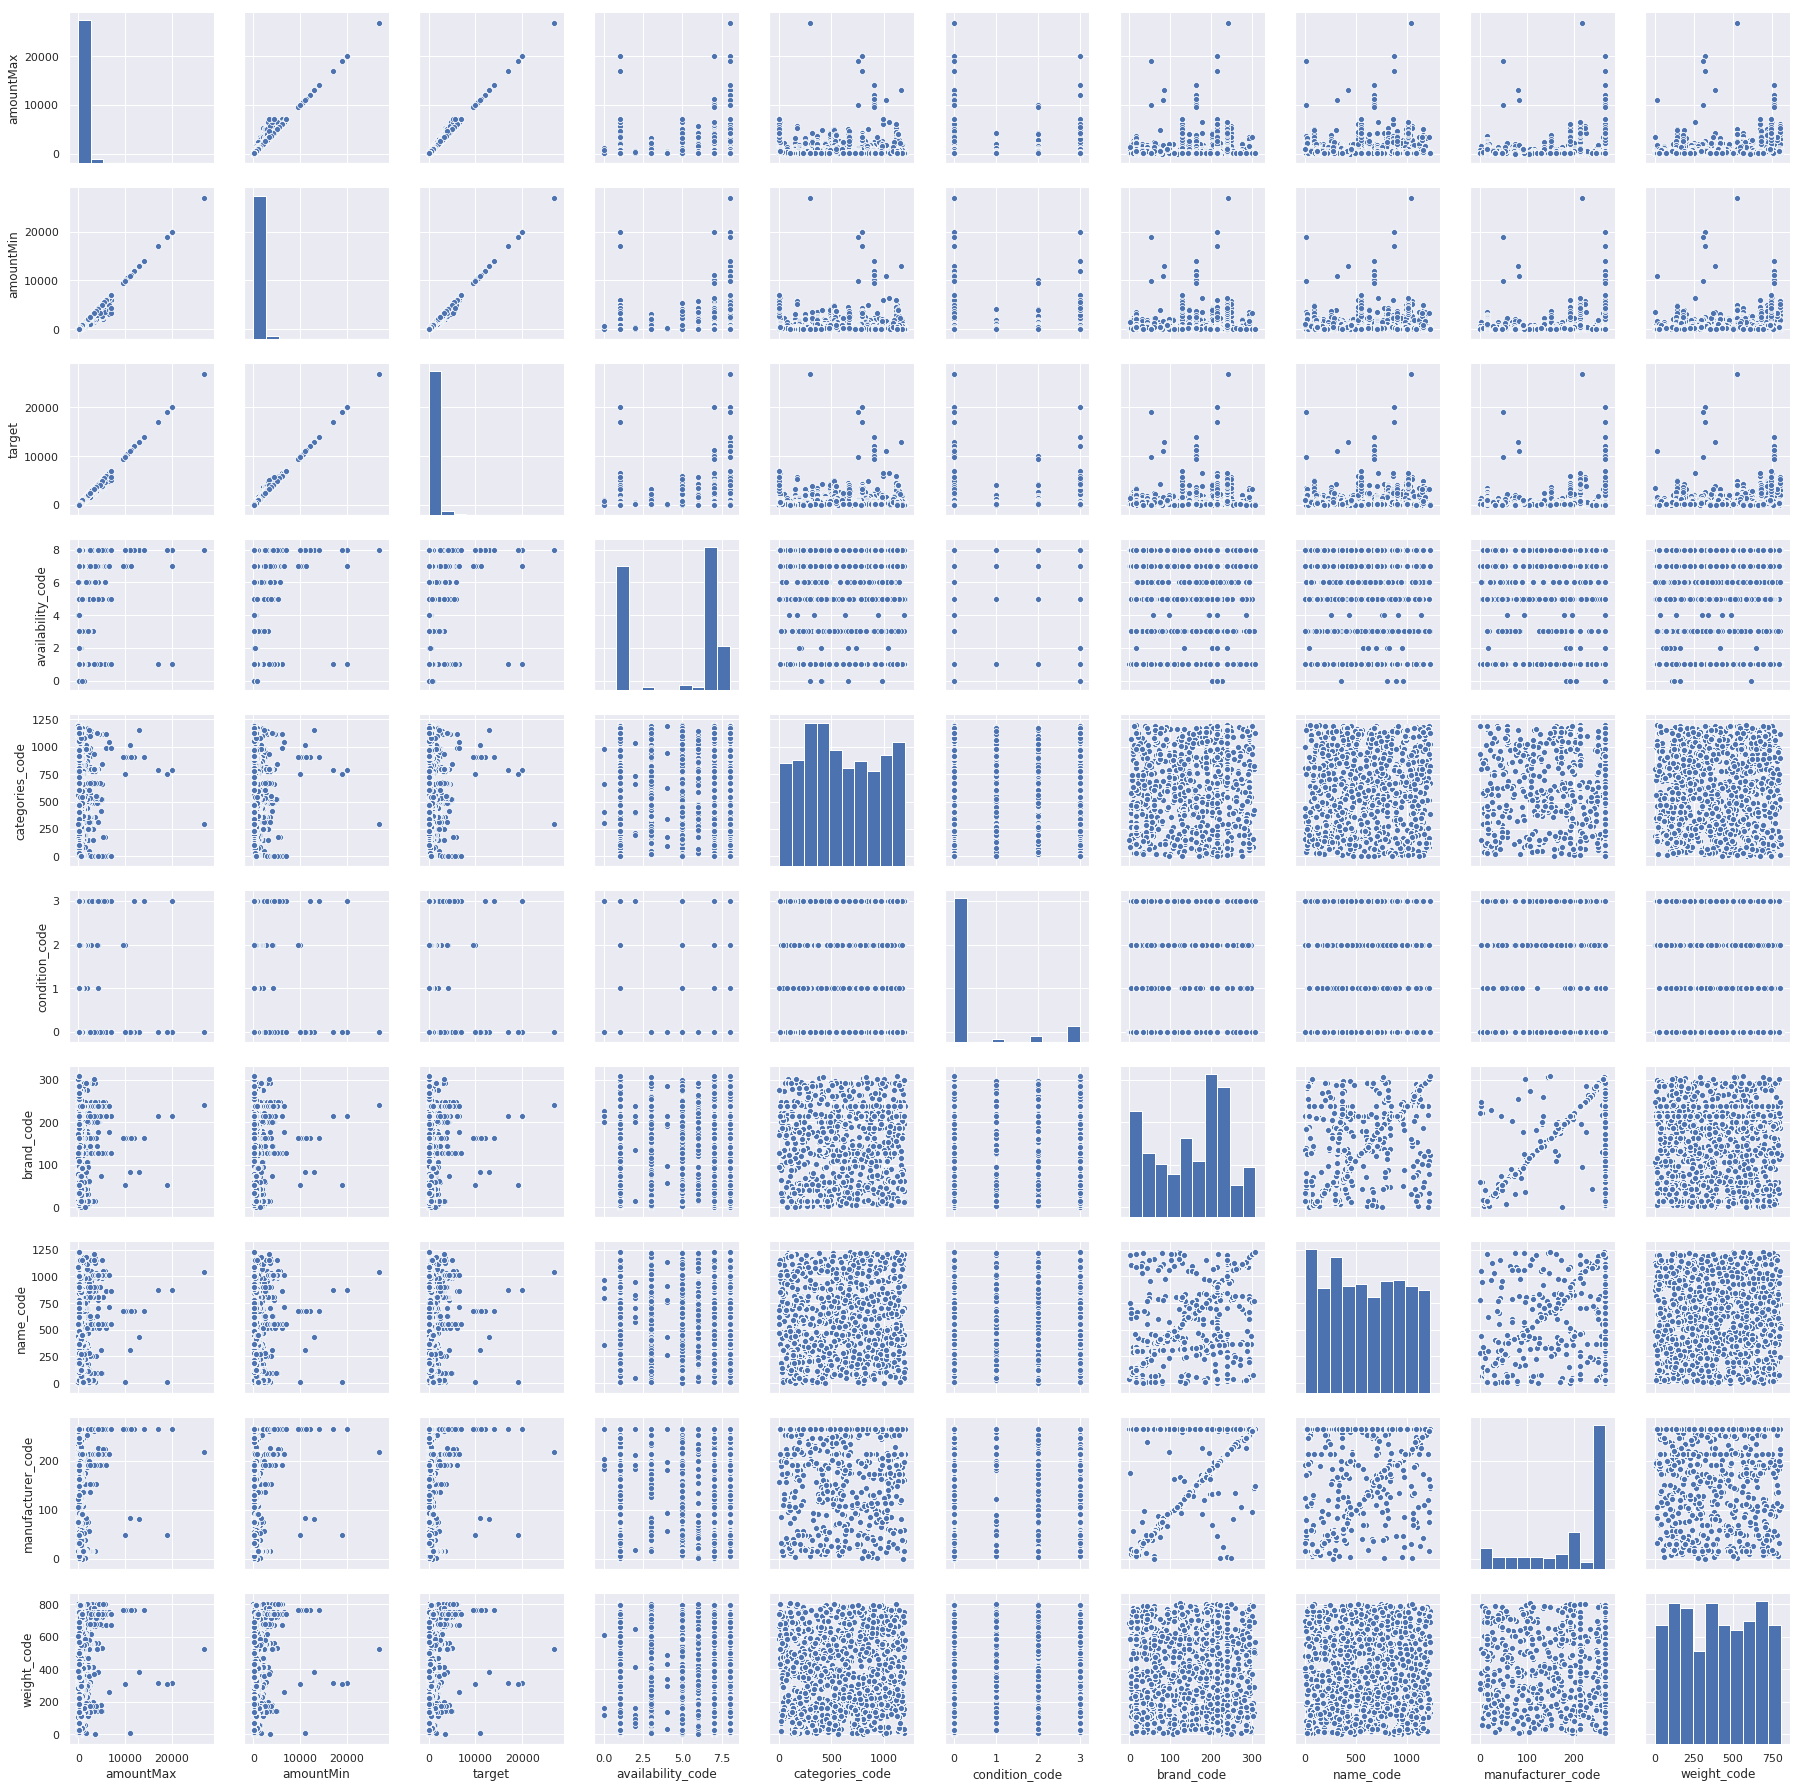

In [48]:
# pairplots showing the relationship and distribution
sns.pairplot(data)

In [0]:
# create training and test datasets
np.random.seed(1234)
data['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(data))
data_train = data[data['runiform'] >= 0.33]
data_test = data[data['runiform'] < 0.33]

In [50]:
# check training data frame
print('\SusItems_train data frame (rows, columns): ',data_train.shape)
print(data_train.head())

\SusItems_train data frame (rows, columns):  (9805, 19)
                     id  amountMax  ...  weight_code  runiform
1  AVpgMuGwLJeJML43KY_c      69.00  ...          274  0.622109
2  AVpgMuGwLJeJML43KY_c      69.00  ...          274  0.437728
3  AVpgMuGwLJeJML43KY_c      69.99  ...          274  0.785359
4  AVpgMuGwLJeJML43KY_c      66.99  ...          274  0.779976
7  AVpgMuGwLJeJML43KY_c      65.99  ...          274  0.801872

[5 rows x 19 columns]


In [51]:
# check test data frame
print('\SusItems_test data frame (rows, columns): ',data_test.shape)
print(data_test.head())

\SusItems_test data frame (rows, columns):  (4787, 19)
                      id  amountMax  ...  weight_code  runiform
0   AVphzgbJLJeJML43fA0o     104.99  ...          537  0.191519
5   AVpgMuGwLJeJML43KY_c      66.00  ...          274  0.272593
6   AVpgMuGwLJeJML43KY_c      74.99  ...          274  0.276464
17  AVpe9FXeLJeJML43zHrq      23.99  ...          135  0.013768
22  AVpfVJXu1cnluZ0-iwTT     289.99  ...          261  0.075381

[5 rows x 19 columns]


In [52]:
# review results for each row
# specify a simple model
my_model = str('target ~ C(availability_code) + C(condition_code) + C(brand_code) + C(categories_code) + C(name_code) + C(manufacturer_code) + C(weight_code)')

# fit the model to the training set
train_model_fit = smf.ols(my_model, data = data_train).fit()
# summary of model fit to the training set
print(train_model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     33.71
Date:                Mon, 01 Jul 2019   Prob (F-statistic):               0.00
Time:                        23:58:24   Log-Likelihood:                -73216.
No. Observations:                9805   AIC:                         1.489e+05
Df Residuals:                    8573   BIC:                         1.578e+05
Df Model:                        1231                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [0]:
data_mix = data.copy()

In [0]:
# create training and test datasets
np.random.seed(1234)
data_mix['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(data_mix))
data_mix_train = data_mix[data_mix['runiform'] >= 0.33]
data_mix_test = data_mix[data_mix['runiform'] < 0.33]

In [55]:
import statsmodels.formula.api as smf
# include conference_code as a classifier
model2 = smf.mixedlm("target ~  brand_code + name_code + weight_code", data_mix_train, groups=data_mix_train["manufacturer_code"])

model2f = model2.fit()

print(model2f.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/mixed_linear_model.py:2059: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/mixed_linear_model.py:2059: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)


            Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  target     
No. Observations:   9805     Method:              REML       
No. Groups:         267      Scale:               926070.0492
Min. group size:    1        Likelihood:          -81406.1700
Max. group size:    4688     Converged:           No         
Mean group size:    36.7                                     
-------------------------------------------------------------
              Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
-------------------------------------------------------------
Intercept     -146.176   43.575 -3.355 0.001 -231.581 -60.771
brand_code       0.511    0.166  3.086 0.002    0.187   0.836
name_code       -0.049    0.037 -1.327 0.185   -0.121   0.023
weight_code      0.994    0.048 20.726 0.000    0.900   1.087
Group Var   143341.775   29.943                              



/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/mixed_linear_model.py:2063: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/mixed_linear_model.py:2075: ConvergenceWarning: Gradient optimization failed, |grad| = 93.493911
  warnings.warn(msg, ConvergenceWarning)


In [0]:
performance = pd.DataFrame(
    {'residuals': model2f.resid.values,
     'predicted': model2f.fittedvalues,
     'brand_code': data_mix_train.brand_code,
     'name_code': data_mix_train.name_code,
     'weight_code': data_mix_train.weight_code,
     'manufacturer_code': data_mix_train.manufacturer_code
    })


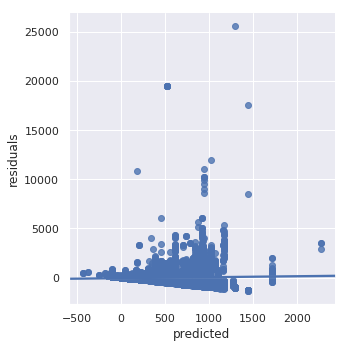

In [94]:
sns.lmplot(x = "predicted", y = "residuals", data = performance)

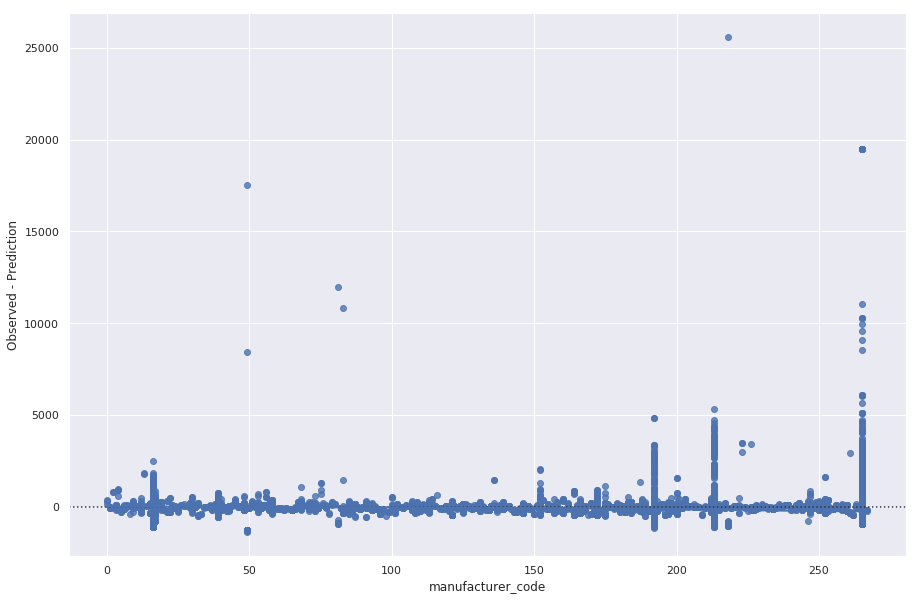

In [95]:
ax = sns.residplot(x = "manufacturer_code", y = "residuals", data = performance, lowess=True)
ax.set(ylabel='Observed - Prediction')
plt.show()